In [6]:
from functools import partial
from sqlite3 import connect

import astroplan as ap
from astropy.coordinates import EarthLocation
from astropy.table import Table
from astropy.time import Time
import astropy.units as u
from icecream import ic, install
import numpy as np
import pandas as pd

import astropaul.targetlistcreator as tlc
import astropaul.lbt as lbt
import astropaul.html as html
import astropaul.phase as ph
import astropaul.priority as pr

install() # icecream will now work in imported packages

%load_ext autoreload
%autoreload 2

# from itables import init_notebook_mode

# init_notebook_mode(
#     all_interactive=True,
#     connected=True,
# )

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\astropy\units\core.py:2080: RuntimeWarning: coroutine 'main' was never awaited
  if hasattr(s, "_get_physical_type_id"):


In [14]:
conn = connect("../../django/TargetDB/db.sqlite3")
html_dir = "html"

session = tlc.ObservingSession(ap.Observer.at_site("LBT"))
session.add_day_range("2024-12-21", "2024-12-28")

phase_event_defs = [
    ph.PhaseEventDef("Mid Eclipse", partial(ph.calc_time_of_phase, phase=0.0)),
    ph.PhaseEventDef("Egress", partial(ph.calc_time_of_gress, ingress=False)),
    ph.PhaseEventDef("Ingress", partial(ph.calc_time_of_gress, ingress=True)),
]

pepsi_args = {
    "fiber": "300",
    "cd_blue": 3,
    "cd_red": 6,
    "snr": 100,
    "binocular": True,
    # "priority": "(see grid)",
}

name = "LBT Observing List 2024-12-21"
creator = tlc.TargetListCreator(name=name, connection=conn)
creator.steps = [
    tlc.add_targets,
    partial(tlc.filter_targets, criteria=lambda df: (df["Target Type"] == "QuadEB")),
    tlc.add_tess,
    tlc.add_coords,
    partial(tlc.hide_cols, prefix="TESS "),
    tlc.add_speckle,
    tlc.add_pepsi,
    tlc.add_lists,
    tlc.add_ephemerides,
    partial(tlc.filter_targets, criteria=lambda df: (df["Num PEPSI"] > 0)),
    partial(tlc.filter_targets, criteria=lambda df: (df["List LBT 2024B"])),
    partial(tlc.concat_dataframe, other_df=pd.read_csv("Calibration Targets.csv")),
    partial(tlc.add_observability, observing_session=session, calc_max_altitude=True, calc_moon_distance=True),
    partial(tlc.filter_targets, criteria=lambda df: (df["Observable Every Night"])),
    partial(tlc.filter_targets, criteria=lambda df: (df["Observable Max Alt"] > 40)),
    partial(tlc.filter_targets, inverse=True, criteria=lambda df: np.isnan(df["Teff"])),
    partial(lbt.add_pepsi_params, **pepsi_args),
    partial(tlc.filter_targets, criteria=lambda df: df["PEPSI exp_time"] < 600),
    partial(lbt.assign_rv_standards, science_types=["QuadEB", "SextEB"], rv_standard_type="RV Standard"),
    partial(tlc.add_phase_events, observing_session=session, phase_event_defs=phase_event_defs),
]
tl = creator.calculate(verbose=False)
tl.target_list["PEPSI notes"] = [type.replace("QuadEB", "Science Target") for type in tl.target_list["Target Type"]]
# readme = lbt.write_lbt_readme_file("UVa_Multistar", tl.target_list)

print(tl.summarize())
print(f"{np.sum(tl.target_list["PEPSI exp_time"])/60:.1f} minutes")
tl.target_list

C:\Users\User\Dropbox\Astro\astropaul\astropaul\lbt\lbt.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  science_targets["RV Standard"] = science_targets["Teff"].apply(find_standard, standards=rv_standards)
C:\Users\User\Dropbox\Astro\astropaul\astropaul\lbt\lbt.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inpl

LBT Observing List 2024-12-21
28 targets:
      16 QuadEB
       9 RV Standard
       3 Telluric Standard
Column Count (primary, secondary):
    Target: (1, 2)
    Coordinates: (6, 3)
    Count: (2, 0)
    List : (0, 10)
    Observable: (4, 21)
    PEPSI : (3, 6)
Associated tables:
     148 rows,  6 columns: Speckle
     103 rows,  8 columns: PEPSI
     656 rows,  6 columns: Ephem
       7 rows,  2 columns: Lunar Phases
    7674 rows,  8 columns: Phase Events

65.2 minutes


,Target Name,Target Source,Target Type,ra,dec,pmra,pmdec,parallax,Vmag,Teff,...,PEPSI fiber,PEPSI cd_blue,PEPSI cd_blue_num_exp,PEPSI cd_red,PEPSI cd_red_num_exp,PEPSI snr,PEPSI exp_time,PEPSI priority,PEPSI notes,RV Standard
0,TIC 367448265,Kostov 2022 arXiv:2202.05790,QuadEB,78.382438,35.653053,-5.85675,-3.432870,3.264150,7.900,9212.00,...,300,3,1,6,1,100,60,,Science Target,HD 102870
1,TIC 25818450,Kostov 2022 arXiv:2202.05790,QuadEB,352.743444,53.069150,3.57360,-1.172130,1.065210,11.782,7172.00,...,300,3,1,6,1,100,341,,Science Target,HD 112299
2,TIC 414026507,Kostov 2022 arXiv:2202.05790,QuadEB,336.837717,56.740362,-3.66449,-2.956470,0.242427,10.899,9187.00,...,300,3,1,6,1,100,137,,Science Target,HD 102870
3,TIC 470710327,Kostov 2022 arXiv:2202.05790,QuadEB,357.329052,61.962787,0.60000,-2.500000,NaN,9.650,8986.00,...,300,3,1,6,1,100,60,,Science Target,HD 102870
4,TIC 89278612,Kostov 2022 arXiv:2202.05790,QuadEB,301.219498,32.643051,-0.48521,-1.506920,0.663315,11.235,8740.00,...,300,3,1,6,1,100,187,,Science Target,HD 102870
5,TIC 278352276,Kostov 2022 arXiv:2202.05790,QuadEB,307.503640,48.607056,1.85387,6.576640,1.362650,10.387,7156.00,...,300,3,1,6,1,100,94,,Science Target,HD 112299
6,TIC 123098844,Kostov 2022 arXiv:2202.05790,QuadEB,279.572843,44.698600,3.48250,-9.104270,1.309250,11.136,6761.00,...,300,3,1,6,1,100,189,,Science Target,HD 693
7,TIC 322727163,Kostov 2022 arXiv:2202.05790,QuadEB,309.716625,50.466821,2.80000,-7.500000,NaN,10.997,7876.56,...,300,3,1,6,1,100,154,,Science Target,HD 102870
8,TIC 427092089,Kostov 2022 arXiv:2202.05790,QuadEB,321.112009,64.380683,-2.81497,-2.828370,0.728287,12.367,8760.00,...,300,3,1,6,1,100,530,,Science Target,HD 102870
9,TIC 454140642,Kostov 2022 arXiv:2202.05790,QuadEB,64.773473,0.900042,2.82736,-10.846600,2.712150,10.409,6592.00,...,300,3,1,6,1,100,97,,Science Target,HD 693


In [15]:
tl.other_lists["Phase Events"]

,Target Name,System,Member,Orbit Num,Event JD,Phase,Event,Event UTC
0,TIC 139621206,A,a,555,2.460666e+06,NaN,Egress,2024-12-21 00:12:51
1,TIC 139621206,A,b,555,2.460666e+06,NaN,Egress,2024-12-21 00:12:51
2,TIC 139621206,B,a,62,2.460666e+06,NaN,Egress,2024-12-21 00:12:51
3,TIC 191283915,A,a,147,2.460666e+06,NaN,Egress,2024-12-21 00:12:51
4,TIC 191283915,A,a,147,2.460666e+06,0.988218,Ingress,2024-12-21 07:10:16
...,...,...,...,...,...,...,...,...
7669,TIC 36439758,A,a,1554,2.460672e+06,NaN,Egress,2024-12-27 00:16:14
7670,TIC 36439758,A,a,1554,2.460672e+06,0.955849,Ingress,2024-12-27 11:00:53
7671,TIC 36439758,A,a,1555,2.460672e+06,0.000000,Mid Eclipse,2024-12-27 12:30:53
7672,TIC 36439758,A,a,1555,2.460672e+06,0.044151,Egress,2024-12-27 14:00:53


In [17]:
illumination_categories = [
    ((0.0, 0.4), "Dark"),
    ((0.4, 0.7), "Gray"),
    ((0.7, 1.0), "Bright"),
]

distance_categories = {
    "Dark": [
        ((0, 180), 1),
    ],
    "Gray": [
        ((0, 5), 0.1),
        ((5, 15), 0.75),
        ((15, 180), 1),
    ],
    "Bright": [
        ((0, 15), 0.25),
        ((15, 30), 0.75),
        ((30, 180), 1),
    ],
}

altitude_categories = [
    ((-90, 35), 0),
    ((35, 45), 0.85),
    ((45, 60), 0.95),
    ((60, 90), 1),
]

phase_defs = [
    ph.PhaseEventDef("T", partial(ph.calc_time_of_phase, phase=0.0)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.05)),
    ph.PhaseEventDef("R", partial(ph.calc_time_of_phase, phase=0.18)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.32)),
    ph.PhaseEventDef("T", partial(ph.calc_time_of_phase, phase=0.45)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.55)),
    ph.PhaseEventDef("R", partial(ph.calc_time_of_phase, phase=0.68)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.82)),
    ph.PhaseEventDef("T", partial(ph.calc_time_of_phase, phase=0.95)),
]

phase_scores = {
    "B|B": 0.5,
    "B|R": 0.8,
    "B|T": 0.4,
    "R|R": 0.9,
    "R|T": 1,
    "T|T": 0.1,
}

science_tl = tl.copy()
science_tl.target_list = science_tl.target_list[science_tl.target_list["Target Type"] == "QuadEB"]
pl = pr.PriorityList(science_tl, session, interval=60 * u.min)
pr.calculate_moon_priority(pl, illumination_categories=illumination_categories, dist_categories=distance_categories)
pr.calculate_altitude_priority(pl, altitude_categories=altitude_categories)
pr.calculate_list_priority(pl, "HQND", false_value=0.75)
pr.calculate_phase_priority(pl, phase_defs=phase_defs, phase_categories=phase_scores)
pr.calculate_overall_priority(pl)
pr.aggregate_target_priorities(pl, skip_column_threshold=0.1)
pl.categorize_priorities(
    bins=[0.00, 0.20, 0.40, 0.6, 1.00], labels=["", "*", "* *", "* * *"]
)

 '2024-12-21T03:00:00.000000000' '2024-12-21T04:00:00.000000000'
 '2024-12-21T05:00:00.000000000' '2024-12-21T06:00:00.000000000'
 '2024-12-21T07:00:00.000000000' '2024-12-21T08:00:00.000000000'
 '2024-12-21T09:00:00.000000000' '2024-12-21T10:00:00.000000000'
 '2024-12-21T11:00:00.000000000' '2024-12-21T12:00:00.000000000'
 '2024-12-21T13:00:00.000000000'], obsgeoloc=[( 5361940.76492377, -477037.13146198, 3414752.90219433),
 ( 5302353.05233912,  928641.03531121, 3414848.24117786),
 ( 4880018.50498485, 2270697.0557764 , 3415825.64635305),
 ( 4123875.43087056, 3457173.43487079, 3417618.15395975),
 ( 3085734.65298114, 4406772.97343364, 3420102.94967791),
 ( 1836729.43870968, 5054429.24127013, 3423109.78327602),
 (  462441.45801932, 5355764.92012714, 3426432.63360449),
 ( -942963.26098071, 5290132.5315241 , 3429843.82468655),
 (-2283186.57551544, 4862029.19917917, 3433109.62570446),
 (-3466396.56383081, 4100788.50670212, 3436006.26599416),
 (-4411519.8360232 , 3058570.56442194, 3438335.267

In [43]:

readme = lbt.write_lbt_readme_file("UVa_Multistar", tl.target_list, session)
with open("UVa_Multistar.README", "w") as f:
    f.write(readme)

other_files = {
    "LBT Readme": lbt.write_lbt_readme_file("UVa_Multistar", tl.target_list, session),
    "LBT CSV": open("UVa_Multistar.csv", "r").readlines(),
}

html.render_observing_pages(tl, pl, other_files, "html")
pl.numerical_priorities[0]

,TIC 89278612,TIC 278352276,TIC 427092089,TIC 414026507,TIC 25818450,TIC 470710327,TIC 283940788,TIC 307119043,TIC 52856877,TIC 389836747,TIC 328181241,TIC 454140642,TIC 367448265,TIC 336882813
2024-12-21 01:00:00,0.57,0.76,0.35625,0.500,0.37500,0.6750,0.35625,0.30000,0.76,0.64125,0.51,0.00,0.00000,0.0000
2024-12-21 02:00:00,0.00,0.68,0.57000,0.475,0.37500,0.5700,0.35625,0.30000,0.80,0.64125,0.57,0.00,0.00000,0.0000
2024-12-21 03:00:00,0.00,0.00,0.63750,0.475,0.35625,0.5700,0.57000,0.30000,0.80,0.60000,0.57,0.68,0.71250,0.0000
2024-12-21 04:00:00,0.00,0.00,0.00000,0.425,0.35625,0.5700,0.57000,0.30000,0.76,0.57000,0.60,0.76,0.35625,0.5100
2024-12-21 05:00:00,0.00,0.00,0.00000,0.000,0.31875,0.6375,0.57000,0.07125,0.76,0.57000,0.57,0.76,0.30000,0.5700
2024-12-21 06:00:00,0.00,0.00,0.00000,0.000,0.00000,0.6375,0.31875,0.07125,0.76,0.35625,0.57,0.76,0.37500,0.6000
2024-12-21 07:00:00,0.00,0.00,0.00000,0.000,0.00000,0.0000,0.00000,0.25500,0.68,0.31875,0.51,0.76,0.37500,0.7500
2024-12-21 08:00:00,0.00,0.00,0.00000,0.000,0.00000,0.0000,0.00000,0.00000,0.00,0.00000,0.00,0.68,0.60000,0.7500
2024-12-21 09:00:00,0.00,0.00,0.00000,0.000,0.00000,0.0000,0.00000,0.00000,0.00,0.00000,0.00,0.00,0.35625,0.7500
2024-12-21 10:00:00,0.00,0.00,0.00000,0.000,0.00000,0.0000,0.00000,0.00000,0.00,0.00000,0.00,0.00,0.71250,0.7125


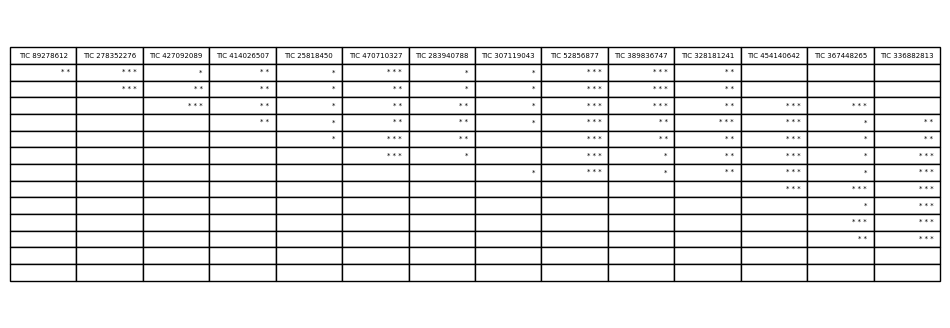

In [12]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

df = pl.categorical_priorities[0].copy()

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis("tight")
ax.axis("off")
the_table = ax.table(cellText=df.values, colLabels=df.columns, loc="center")

pp = PdfPages("foo.pdf")
pp.savefig(fig, bbox_inches="tight")
pp.close()

In [4]:
from playwright.sync_api import sync_playwright


def html_to_pdf(input_html_path, output_pdf_path):
    with sync_playwright() as p:
        # Launch a browser
        browser = p.chromium.launch()
        page = browser.new_page()

        # Load the local HTML file
        page.goto(input_html_path)

        # Generate the PDF
        page.pdf(path=output_pdf_path, format="A4")
        print(f"PDF saved to {output_pdf_path}")

        # Close the browser
        browser.close()


# Call the function
html_to_pdf("test.html", "asd.pdf")

Error: It looks like you are using Playwright Sync API inside the asyncio loop.
Please use the Async API instead.

In [9]:
with open("html/Categorical Priorities 2024-12-21.html", "r") as f:
    content = f.read()

from playwright.sync_api import sync_playwright

with sync_playwright() as p:
    browser = p.chromium.launch()
    page = browser.new_page()
    # page.set_content(content)
    page.goto("file://test.html")
    page.pdf("foo.pdf")
    browser.close()

Error: It looks like you are using Playwright Sync API inside the asyncio loop.
Please use the Async API instead.